# Speaker Diarization with two features - MFCCs and ZCR

In [2]:
import os
import librosa
import pandas as pd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from spectralcluster import SpectralClusterer

In [3]:
def read_audio(audio_path):
    (sampling_rate, audio_data) = wavfile.read(audio_path)
    return sampling_rate, audio_data

In [4]:
def visualize_audio_wave_over_time(sampling_rate, audio_data):
    time_array = np.arange(audio_data.size)/sampling_rate
    plt.plot(time_array, audio_data)
    plt.show()

In [5]:
# Ref: https://hackernoon.com/audio-handling-basics-how-to-process-audio-files-using-python-cli-jo283u3y
def get_audio_segments(audio_data, segment_size, sr):
    # Fix-sized segmentation (breaks a signal into non-overlapping segments)
    signal_len = len(audio_data)
    segment_size_t = segment_size # segment size in seconds
    segment_size = segment_size * sr  # segment size in samples
    # Break signal into list of segments in a single-line Python code
    segments = np.array([audio_data[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)])
    return segments

In [6]:
def normalize_audio(audio_data, sr):
    # Ref: https://hackernoon.com/audio-handling-basics-how-to-process-audio-files-using-python-cli-jo283u3y
    audio_data_norm = audio_data / (2**15)
    visualize_audio_wave_over_time(sr, audio_data_norm)
    return audio_data_norm

## Diarization

In [33]:
# Read preprocessed file
audio_filename = "preprocessed_wo_noise_video_playback_scrum_cropped.wav"
fs_wav, data_wav = read_audio("audios/preprocessed/"+audio_filename)

print('Signal Duration = {} seconds'.
      format(data_wav.shape[0] / fs_wav))

print("Sampling rate: ", fs_wav)

Signal Duration = 177.8 seconds
Sampling rate:  44100


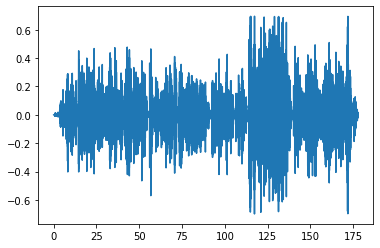

In [34]:
data_wav_norm = normalize_audio(data_wav, fs_wav)

In [36]:
segments = get_audio_segments(data_wav_norm, 1, fs_wav)

### Feature extraction

In [37]:
# MFCC
def get_mfcc_feature(ad, sr):
    mfccs = librosa.feature.mfcc(ad, sr=sr)
    return mfccs

In [38]:
# Feature extraction - MFCCs, Zero Crossing Rate
all_features = []
for idx, arr in enumerate(segments):
    print(idx)
    features_list = []
    mfccs = get_mfcc_feature(arr, fs_wav)
    features_list.append(np.mean(librosa.feature.zero_crossing_rate(arr)))

    for mfcc in mfccs:
        features_list.append(np.mean(mfcc))
    
    all_features.append(features_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177


In [39]:
df = pd.DataFrame(all_features)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.009294,-823.790601,74.888471,-5.502535,9.233681,13.400615,13.419218,-8.628619,9.191462,0.698609,...,-2.901726,2.954062,0.267227,-3.072063,2.175729,-0.846479,-1.043873,-1.507156,2.047330,0.127826
1,0.043541,-616.844116,148.375822,-17.667817,22.070118,21.378174,33.011195,-15.764962,20.157377,-4.464370,...,-7.423712,6.082803,3.718525,-0.553355,4.801935,-4.138611,-3.997620,-4.615530,3.967253,-0.591038
2,0.053767,-625.352517,148.610580,-15.948462,18.496530,15.828938,27.378113,-19.685591,10.732429,-5.346947,...,-2.646346,6.490943,3.489631,0.151756,6.031154,3.059307,3.184469,0.762207,5.060028,1.517444
3,0.040398,-532.688729,175.377706,-13.562108,-9.183811,34.527160,14.116690,-25.955032,-4.431650,-4.105424,...,-2.192620,5.994386,1.956235,-1.385780,3.194617,-3.592040,-2.645004,1.201284,1.908153,-6.521941
4,0.040241,-435.270841,224.279385,-29.685633,-27.784896,31.221271,19.041289,-31.570028,-6.991043,-9.735833,...,-4.840882,4.882265,-1.918707,-6.183457,-1.057062,-12.809560,-9.778398,-2.283176,1.417487,-9.051152


In [40]:
# Feature scaling
df_scaled = df.copy()

for c in list(df.columns):
    df_column = df[c]
    min_value = df_column.min()
    max_value = df_column.max()
    norm_data = (df_column - min_value) / (max_value - min_value)
    df_scaled[c] = norm_data

df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.000000,0.000000,0.000000,0.498079,0.520342,0.265725,0.508410,0.742435,0.781270,0.746562,...,0.720289,0.606380,0.456617,0.520987,0.408561,0.603319,0.579214,0.550341,0.537981,0.807927
1,0.445239,0.385814,0.486876,0.304464,0.679149,0.357329,0.860512,0.601094,0.966369,0.589707,...,0.538375,0.722612,0.577462,0.595295,0.560180,0.442126,0.453884,0.390369,0.645189,0.765525
2,0.578183,0.369952,0.488432,0.331828,0.634938,0.293609,0.759276,0.523443,0.807281,0.562893,...,0.730563,0.737775,0.569447,0.616097,0.631147,0.794558,0.758627,0.667133,0.706209,0.889892
3,0.404378,0.542707,0.665772,0.369808,0.292489,0.508316,0.520945,0.399272,0.551319,0.600612,...,0.748816,0.719328,0.515756,0.570736,0.467385,0.468888,0.511277,0.689731,0.530209,0.415695
4,0.402335,0.724325,0.989761,0.113196,0.062364,0.470356,0.609448,0.288062,0.508118,0.429556,...,0.642279,0.678012,0.380078,0.429194,0.221922,0.017570,0.208600,0.510403,0.502810,0.266511


### Clustering

#### DBSCAN

In [41]:
def dbscan_clustering(X, epsilon=0.5, minimum_samples=5):
    model = DBSCAN(eps=epsilon, min_samples=minimum_samples, n_jobs=-1)
    clusters = model.fit_predict(X)

    return dict(model=model, score=None, clusters=clusters)

In [45]:
print(dbscan_clustering(df_scaled, epsilon=0.6, minimum_samples=2))

{'model': DBSCAN(eps=0.6, min_samples=2, n_jobs=-1), 'score': None, 'clusters': array([-1, -1, -1,  0, -1, -1,  0,  0,  1,  0, -1,  0, -1,  0,  0, -1,  0,
       -1,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  2, -1, -1,  0,  3,  4,
       -1,  0, -1,  0,  0, -1,  0, -1, -1, -1,  4,  0,  0,  0, -1, -1, -1,
        0, -1,  0,  0,  0, -1,  1, -1,  0,  0,  2,  0,  0,  0, -1,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,  0, -1,  2,  0, -1,
        0,  0,  0,  0, -1,  0, -1, -1,  0, -1, -1,  0, -1,  0,  0, -1, -1,
        0,  0, -1,  0,  0,  0, -1, -1, -1, -1,  0,  0,  5, -1,  0, -1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1,  0,  3,  0,  0,  5, -1, -1,  0, -1,
       -1, -1,  0,  0, -1, -1, -1,  6,  6, -1,  6, -1, -1,  7,  0,  7,  0,
        0, -1, -1,  8, -1,  0,  9,  0, -1,  6,  8,  0, -1,  0, -1,  0,  9,
        0, 10, 10,  9,  0, -1, -1, -1])}


#### K-Means

In [46]:
def simple_k_means(X, n_clusters=3, score_metric='euclidean'):
    model = KMeans(n_clusters=n_clusters)
    clusters = model.fit_transform(X)

    # There are many methods of deciding a score of a cluster model. Here is one example:
    score = metrics.silhouette_score(X, model.labels_, metric=score_metric)
    print(score)
    return dict(model=model, score=score, clusters=clusters)

In [47]:
# Passing 5 clusters because there are 5 speakers - Change as per the video
model_data = simple_k_means(df_scaled, n_clusters=5)
model_data['model'].labels_

0.13826229712130178


array([2, 0, 0, 1, 4, 4, 1, 4, 4, 2, 2, 3, 4, 2, 2, 4, 4, 1, 2, 2, 2, 2,
       2, 4, 4, 4, 2, 1, 1, 1, 1, 2, 4, 4, 2, 4, 2, 2, 2, 2, 3, 2, 4, 4,
       4, 2, 2, 0, 4, 1, 0, 4, 4, 1, 0, 0, 4, 4, 0, 3, 3, 3, 3, 3, 0, 4,
       3, 2, 3, 3, 3, 3, 0, 2, 3, 3, 0, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 2, 2, 4, 4, 2, 2, 1, 0, 2, 1, 2, 1, 2, 0, 1, 0, 4, 0,
       4, 1, 0, 0, 4, 4, 2, 4, 2, 1, 4, 4, 2, 1, 4, 4, 4, 4, 2, 2, 4, 4,
       4, 4, 4, 2, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 4, 4, 1, 0, 1,
       1, 0], dtype=int32)

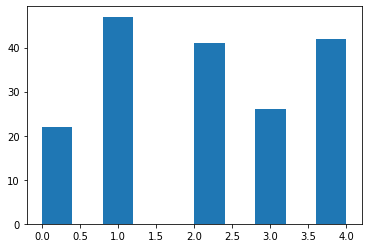

In [48]:
df['clusters'] = list(model_data['model'].labels_)

fig, ax = plt.subplots()
ax.hist(df['clusters'])
plt.show()

In [49]:
df.to_csv("clusters/kmeans_clusters_without_noise_preprocessed.csv", index=False)

#### Spectral

In [51]:
# Replace min_clusters value with the number of speakers if the audio
clusterer = SpectralClusterer(
    min_clusters=5,
    max_clusters=100,
    p_percentile=0.90,
    gaussian_blur_sigma=1)

labels = clusterer.predict(df_scaled.values)
labels

array([2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0,
       0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int32)

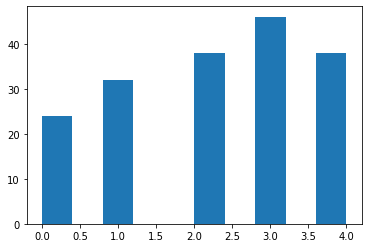

In [52]:
df['clusters'] = list(labels)

fig, ax = plt.subplots()
ax.hist(df['clusters'])
plt.show()

In [53]:
df.to_csv("clusters/spectral_clusters_without_noise_preprocessed.csv", index=False)

### Audio Grouping

In [55]:
def group_audios_based_on_clusters(dfx, audio_segments, sr):
    clusters = dfx['clusters']
    label_indexes_dict = {}
    label_audio_clusters = {}

    for idx, label in enumerate(clusters):
        if label in label_indexes_dict.keys():
            label_indexes_dict[label].append(idx)
        else:
            label_indexes_dict[label] = [idx]

    for k, v in label_indexes_dict.items():
        # get segments that have energies higher than a the threshold:
        clustered_segments = audio_segments[v]

        # concatenate segments to signal:
        audio_cluster = np.concatenate(clustered_segments)

        label_audio_clusters[k] = audio_cluster

    return label_audio_clusters

In [56]:
# Save all clusters
def save_audio_clusters(dir_name, speaker_audio_dict, sr):
    if not os.path.exists("clusters/"+dir_name):
        os.makedirs("clusters/"+dir_name)

    for speaker, audio in speaker_audio_dict.items():
        wavfile.write("clusters/"+dir_name+"/"+str(speaker)+".wav", sr, audio)

In [57]:
# Saving K-means audio clusters
fs_wav, data_wav = read_audio("audios/preprocessed/"+audio_filename)
segments = get_audio_segments(data_wav, 1, fs_wav)

df_kmeans_clusters_preprocessed = pd.read_csv("clusters/kmeans_clusters_without_noise_preprocessed.csv")

speaker_audio_dict = group_audios_based_on_clusters(df_kmeans_clusters_preprocessed, segments, fs_wav)
save_audio_clusters("kmeans_clusters_without_noise_preprocessed", speaker_audio_dict, fs_wav)

In [58]:
# Saving Spectral audio clusters
fs_wav, data_wav = read_audio("audios/preprocessed/"+audio_filename)
segments = get_audio_segments(data_wav, 1, fs_wav)

df_spectral_clusters_preprocessed = pd.read_csv("clusters/spectral_clusters_without_noise_preprocessed.csv")

speaker_audio_dict = group_audios_based_on_clusters(df_spectral_clusters_preprocessed, segments, fs_wav)
save_audio_clusters("spectral_clusters_without_noise_preprocessed", speaker_audio_dict, fs_wav)